In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,optimizers,losses,regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Hyper Parameters


In [23]:
columns=["files","labels"]
LABELS=["non_fire_images","fire_images"]
PATH="D:\\df\\ai\\fire_dataset"
IMAGE_WIDTH=512
IMAGE_HEIGHT = 512
BACH_SIZE= 4
LR=1e-4
CSV_PATH="../history.csv"
MODEL_SAVE="../firemodel"
N_EPOCHS=150
LAMBDA=0.2

# Data Preparation

In [27]:

def load_data(path,train=True):
    images=[]
    labels=[]

    if train :
        df=pd.read_csv("../train.csv",names=columns,header=1)
    else:
        df=pd.read_csv("test.csv",names=columns,header=1)
    
    for _,row in df.iterrows():
        label=int(row["labels"])
        labels.append(label)
        images.append(os.path.join(path,"train",LABELS[label],row["files"]))
    return images,labels
    
def load_dataset(path,test_size=0.1,random_state=18):
    images,labels=load_data(path)
    train_images,val_images=train_test_split(images,test_size=test_size,random_state=random_state)
    train_labels,val_labels=train_test_split(labels,test_size=test_size,random_state=random_state)

    return (train_images,train_labels),(val_images,val_labels)


def read_images(image_path,label):
    image=tf.io.read_file(image_path)
    image=tf.io.decode_jpeg(image)
    height,width,channels=image.shape
    image=tf.image.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if channels==1:
        image=tf.image.grayscale_to_rgb(image)
    
    image=np.array(image,dtype=np.float32)
    if channels==4:
        image = image[:,:,:3]
    image=2*(image/255)-1

    label=np.float32(label)

     
    return image,label
def load_tensors(images,labels):
    images,labels=tf.numpy_function(read_images,[images,labels],[tf.float32,tf.float32])
    return images,labels

    
def tfData(images,labels):
    ds=tf.data.Dataset.from_tensor_slices((images,labels))
    ds=ds.map(load_tensors,num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.cache()
    ds=ds.batch(1)
    ds=ds.prefetch(tf.data.AUTOTUNE)
    return ds

(train_images,train_labels),(val_images,val_labels)=load_dataset(PATH)

ds_train=tfData(train_images,train_labels)
ds_val=tfData(val_images,val_labels)

print(f"train :{len(train_images)}")
print(f"val   :{len(val_images)}")

train :897
val   :100


# Build Model

In [4]:
class CNNBlock(layers.Layer):
    def __init__(self,filter_size,channels,padding="same",filter_stride=1,pool_info=None):
        super(CNNBlock,self).__init__()
        self.dopool=False
        self.conv=layers.Conv2D(channels,filter_size,filter_stride,padding=padding)
        self.batch=layers.BatchNormalization()
        if pool_info != None:
            self.pooling=layers.MaxPool2D(pool_info[0],pool_info[1])
            self.dopool=True
    
    def call(self,inputs,training=False):
        x=self.conv(inputs)
        x=self.batch(x,training=training)
        x=tf.nn.relu(x)
        if self.dopool:
            x=self.pooling(x)
        return x




class AlexNet(tf.keras.Model):
    def __init__(self):
        super(AlexNet,self).__init__()

        self.cnn1=CNNBlock((11,11),96,'valid',4,((3,3),2))
        self.cnn2=CNNBlock((5,5),256,pool_info=((3,3),2))
        self.cnn3=CNNBlock((3,3),384)
        self.cnn4=CNNBlock((3,3),384)
        self.cnn5=CNNBlock((3,3),256,pool_info=((3,3),2))
        self.outputlayer=layers.Dense(1,activation="sigmoid")
    def call(self,inputs,training=False):
        x=self.cnn1(inputs,training)
        x=self.cnn2(x,training=training)
        x=self.cnn3(x,training=training)
        x=self.cnn4(x,training=training)
        x=self.cnn5(x,training=training)
        x=layers.Flatten()(x)
        x=self.outputlayer(x,training=training)
        return x


model=AlexNet()
inputs=keras.Input((IMAGE_HEIGHT,IMAGE_WIDTH,3))
outputs=model(inputs)


model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()
model.compile(
        loss=losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(LR), metrics=[keras.metrics.BinaryAccuracy()]
    )



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 alex_net (AlexNet)          (None, 1)                 3802881   
                                                                 
Total params: 3,802,881
Trainable params: 3,800,129
Non-trainable params: 2,752
_________________________________________________________________


# Training

In [5]:
callbacks = [
        ModelCheckpoint(MODEL_SAVE, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7,min_delta=0.001, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
        CSVLogger(CSV_PATH,append=False)
    ]

history=model.fit(
        ds_train,
        epochs=N_EPOCHS,
        validation_data=ds_val,
        verbose=1,
        batch_size=BACH_SIZE,
        callbacks=callbacks
    )

Epoch 1/150
225/225 [==============================] - ETA: 0s - loss: 0.3727 - binary_accuracy: 0.8763
Epoch 1: val_loss improved from inf to 0.23445, saving model to firemodel


INFO:tensorflow:Assets written to: firemodel\assets


INFO:tensorflow:Assets written to: firemodel\assets


225/225 [==============================] - 34s 130ms/step - loss: 0.3727 - binary_accuracy: 0.8763 - val_loss: 0.2344 - val_binary_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 2/150
224/225 [============================>.] - ETA: 0s - loss: 0.2071 - binary_accuracy: 0.9342
Epoch 2: val_loss improved from 0.23445 to 0.12560, saving model to firemodel


INFO:tensorflow:Assets written to: firemodel\assets


INFO:tensorflow:Assets written to: firemodel\assets


225/225 [==============================] - 23s 101ms/step - loss: 0.2068 - binary_accuracy: 0.9342 - val_loss: 0.1256 - val_binary_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 3/150
224/225 [============================>.] - ETA: 0s - loss: 0.1374 - binary_accuracy: 0.9453
Epoch 3: val_loss did not improve from 0.12560
225/225 [==============================] - 20s 87ms/step - loss: 0.1372 - binary_accuracy: 0.9454 - val_loss: 0.1678 - val_binary_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 4/150
224/225 [============================>.] - ETA: 0s - loss: 0.1086 - binary_accuracy: 0.9598
Epoch 4: val_loss improved from 0.12560 to 0.06156, saving model to firemodel


INFO:tensorflow:Assets written to: firemodel\assets


INFO:tensorflow:Assets written to: firemodel\assets


225/225 [==============================] - 22s 99ms/step - loss: 0.1085 - binary_accuracy: 0.9599 - val_loss: 0.0616 - val_binary_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 5/150
224/225 [============================>.] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9654
Epoch 5: val_loss improved from 0.06156 to 0.05957, saving model to firemodel


INFO:tensorflow:Assets written to: firemodel\assets


INFO:tensorflow:Assets written to: firemodel\assets


225/225 [==============================] - 24s 106ms/step - loss: 0.0889 - binary_accuracy: 0.9654 - val_loss: 0.0596 - val_binary_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/150
224/225 [============================>.] - ETA: 0s - loss: 0.0834 - binary_accuracy: 0.9688
Epoch 6: val_loss did not improve from 0.05957
225/225 [==============================] - 20s 87ms/step - loss: 0.0833 - binary_accuracy: 0.9688 - val_loss: 0.0932 - val_binary_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 7/150
224/225 [============================>.] - ETA: 0s - loss: 0.0545 - binary_accuracy: 0.9788
Epoch 7: val_loss did not improve from 0.05957
225/225 [==============================] - 19s 86ms/step - loss: 0.0544 - binary_accuracy: 0.9788 - val_loss: 0.1515 - val_binary_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 8/150
224/225 [============================>.] - ETA: 0s - loss: 0.0469 - binary_accuracy: 0.9810
Epoch 8: val_loss did not improve from 0.05957
225/225 [==============================] - 25s 110ms/s

# Evaluation

# training history

['epoch', 'binary_accuracy', 'loss', 'lr', 'val_binary_accuracy', 'val_loss']


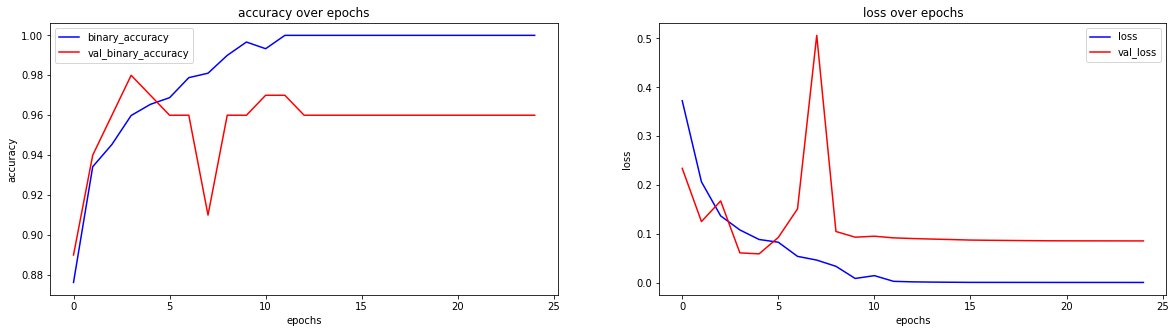

In [18]:
df=pd.read_csv("../history.csv")
x=np.arange(df.shape[0])

print(list(df.keys()))
infos=[["accuracy","binary_accuracy","val_binary_accuracy"],["loss","loss","val_loss"]]

fig,axes=plt.subplots(1,2,figsize=(20,5))
for i in range(0,2):
    axes[i].set_title(f"{infos[i][0]} over epochs")
    axes[i].set_xlabel("epochs")
    axes[i].set_ylabel(infos[i][0])
    axes[i].plot(x,df[infos[i][1]],label=infos[i][1],c="blue")
    axes[i].plot(x,df[infos[i][2]],label=infos[i][2],c="red")
    axes[i].legend()

## Metrics for testing

In [28]:
model=tf.keras.models.load_model(MODEL_SAVE)
ds_test=tfData(val_images,val_labels)
ds_test = iter(ds_test)
classes=[0,1]
labels=[]
preds=[]
for images,label in ds_test:
    pred_label=model.predict(images,verbose=0)
    preds.append(1 if pred_label > 0.5 else 0)
    labels.append(label)
print(preds)
print(f"accuracy score is :{accuracy_score(labels,preds)}")    
print(f"f1 score is :{f1_score(labels,preds)}")    

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
accuracy score is :0.97
f1 score is :0.980891719745223
